In [6]:
import sys
import gc

import torch
import numpy as np


PYTHONPATH = sys.executable

# set song
#song_name = "songs/gnossi_1.mp3"
#song_name = "songs/henne_song.mp3"
#song_name = "songs/Präludium_1_bach.mp3"
#song_name = "songs/Präludium_2_Bach.mp3"
song_name = "songs/Blumen.wav"
#song_name = "songs/Misty.mp3"
#song_name = "songs/space_is_the_place_men_I_trust.mp3"
#song_name = "songs/opus_men_I_trust.mp3"
#song_name = "songs/any_colour_you_like_pink_floyd_hd_studio_quality_7032261705832661515.mp3"

# set some parameters based on how much memory is available
gpu_avail = 8

clip_batch_size = 4
gpt_name = "gpt2"
if gpu_avail > 8:
    clip_batch_size = 4
    gpt_name = "neo1.3"
elif gpu_avail == 12:
    clip_batch_size = 8
    gpt_name = "neo2.7"
    
# general params
fps = 15
boost_fps = 60
# musicnn params
input_overlap = 1 / 30
input_length = 3
# song params
offset = 0
duration = None
# post processing params
upscale = True
twice_upscale = False
# video params
total_effect_strength = 0.5
ema_val = 0.2 # 0.99 is too strong
ema_val_latent = 0.25
sub_steps = 50
lpips_weight = 2.5  # 1.5 is good for 300 sub_steps but more could work too.
# prompts
base_img_path = "../CLIP_playground/base_images/"
# settings for prompts
k = 5
prompt_mode = "top_k" # top_k, weighted_top_k, gpt
taggram_mode = "feelings" # full, feelings
prefix = ""
general_theme = "" #". In the style of James Gurney."
create_gpt_artstyle = True
num_themes = 10 # num GPT themes to sample
create_clusters = True
do_create_gpt_cluster_stories = True
size_gpt_story_selection = 10  # how many stories are created and later selected by CLIP
min_clusters = 3
max_clusters = 10
gpt_story_top_k = 2  # number of k top cluster stories that will be consideren in CLIP guidance
img_theme = None # base_img_path + "hot-dog.jpg"
# base_img_path + "Autumn_1875_Frederic_Edwin_Church.jpg"
#". By Pete Mohrbacher."
#". In the style of 'The Persistence of Memory' by Dali." #" by madziowa_p." #" by Jan Brueghel the Elder."  #" by Salvador Dali." #" by Greg Rutkowski."

In [7]:
import soundfile
import librosa
import os

resampled_path = "tmp/resampled.wav"
os.makedirs("tmp", exist_ok=True)

# load song and resample to 16k Hz
sr = 16000
raw_song, old_sr = librosa.load(song_name, offset=offset, duration=duration)
song = librosa.resample(raw_song, old_sr, sr)
soundfile.write(resampled_path, song, sr)

In [8]:
import pandas as pd
from mustovi_utils import get_taggram
    
tag_dfs_folder = "./tmp/tag_dfs"
os.makedirs(tag_dfs_folder, exist_ok=True)
key_song_name = song_name.split("/")[-1].split(".")[0]
tag_df_name = f"{key_song_name}_{input_length}_{int(1 / input_overlap)}_{offset}_{duration}.csv"
tag_df_path = os.path.join(tag_dfs_folder, tag_df_name)
if os.path.exists(tag_df_path):
    normed_tag_df = pd.read_csv(tag_df_path, index_col=0)
else:
    normed_tag_df = get_taggram(resampled_path, input_overlap, input_length)
    normed_tag_df.to_csv(tag_df_path)
    torch.cuda.empty_cache()
    gc.collect()

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
# ordered by importance
show_all_labels = False
if show_all_labels:
    plt.figure(figsize=(12, 20))
    show_df = normed_tag_df.T.copy()
    show_df["mean"] = normed_tag_df.mean(axis=0)
    show_df = show_df.sort_values("mean").drop(columns=["mean"])
    sns.heatmap(show_df)
    plt.tight_layout()

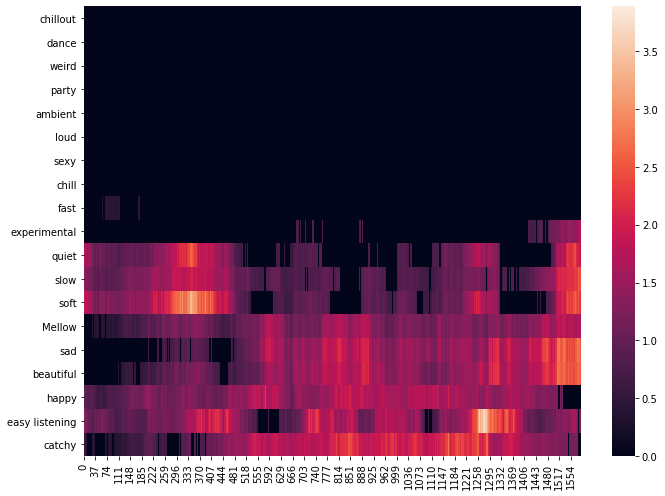

In [10]:
instruments = ["violin", "strings", "sitar", "piano", "harpsichord", 
               "harp", "guitar", "drums", "flute", "synth", "cello"]
genres = ["techno", "soul", "rock", "rnb", "punk", "pop", "opera", 
          "oldies", "new age", "metal", "jazz", "indie rock", "indie pop",
          "indie", "indian", "heavy metal", "hard rock", "funk", "folk", 
          "electronica", "electronic", "country", "classical", "classic rock",
          "classic", "choral", "blues", "alternative rock", "alternative",
          "Progressive rock", "House", "Hip-hop"]
eras = ["60s", "70s", "80s", "90s", "00s"]

speed_tags = ["fast", "slow"]
feeling_tags = ["weird", "soft", "happy", "sad", "catchy", "easy listening", "sexy", "chillout", "beautiful", "chill"]
loudness_tags = ["quiet", "loud"]
vibe_tags = ["ambient", "party", "dance", "Mellow", "experimental"]

genre_like_tags = ["solo", "blues", "Beat"]

feeling_tags = speed_tags + feeling_tags + loudness_tags + vibe_tags
    
plt.figure(figsize=(10, 7))
show_df = normed_tag_df[feeling_tags].T.copy()
show_df[show_df < show_df.mean(axis=0)] = 0
show_df["mean"] = show_df.mean(axis=1)
show_df = show_df.sort_values("mean").drop(columns=["mean"])
sns.heatmap(show_df)
plt.tight_layout()

In [17]:
# reduce taggram to fit fps
musicnn_fps = 62.5
#averaging_window = int(musicnn_fps / fps) # == 2 - 30fps
averaging_window = int(np.round(musicnn_fps / fps)) # == 3 - 20fps
# take step average taggram
fps_taggram = normed_tag_df.rolling(averaging_window, min_periods=1, axis=0).mean() 
fps_taggram = fps_taggram.iloc[::averaging_window, :]

In [19]:
# decide on using only subset
used_tag_df = fps_taggram.copy()
if taggram_mode == "feelings":    
    used_tag_df = used_tag_df[feeling_tags]
    
# rename some columns
rename_dict = {"sexy": "sensual",
               "party": "energetic",
               "dance": "moving",
               "easy listening": "harmonious",
               "catchy": "captivating"}
used_tag_df = used_tag_df.rename(columns=rename_dict)
# merge some columns
merge_dict = {"chill": "chillout"}
for key in merge_dict:
    val = merge_dict[key]
    used_tag_df[val] = (used_tag_df[key] + used_tag_df[val]) / 2
    del used_tag_df[key]

tag_df_means = used_tag_df.mean()
used_tag_df[used_tag_df < tag_df_means] = 0

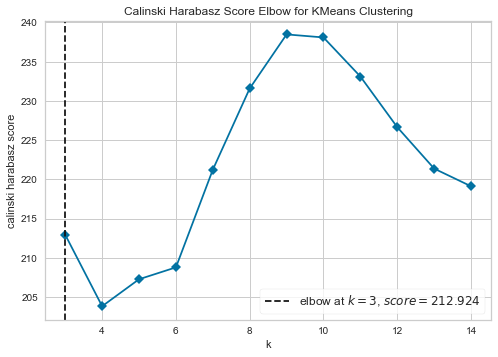

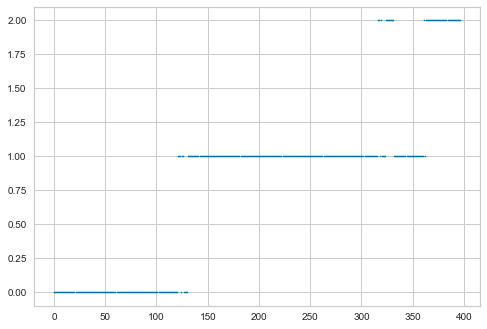

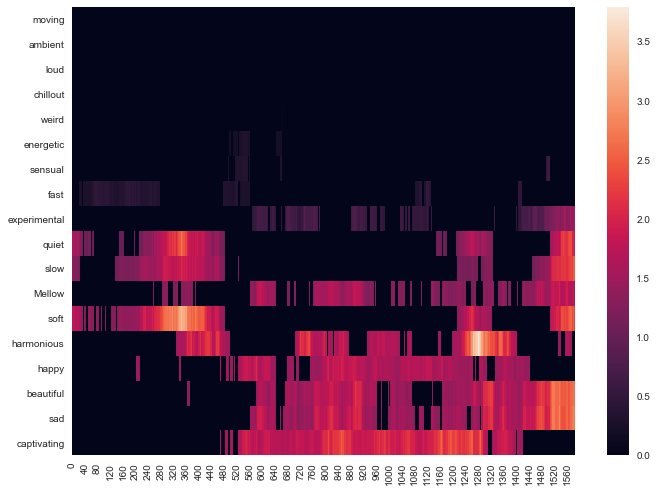

In [20]:
# create clusters
if create_clusters:
    from umap import UMAP
    import sklearn
    
    clustering_feats = used_tag_df.to_numpy()
    # add index to give some time continuity
    cluster_time = False
    if cluster_time:
        print(clustering_feats.shape)
        idx_arr = np.expand_dims(np.arange(len(clustering_feats)), 1)
        idx_arr = idx_arr / idx_arr.std() * 20
        clustering_feats = np.concatenate([clustering_feats, idx_arr], axis=1)
    # create high dim umap embeddings for clustering
    cluster_on_umap_high_d = False
    if cluster_on_umap_high_d:
        print("Umapping...")
        clusterable_embedding = UMAP(
            n_neighbors=30,
            min_dist=0.0,
            n_components=10,
            random_state=42,
            metric="cosine",
        ).fit_transform(clustering_feats)
    else:
        clusterable_embedding = clustering_feats
    
    use_k_means = True
    # cluster
    if not use_k_means:
        import hdbscan

        num_clusters = 0
        min_samples = 3
        while max_clusters < num_clusters or num_clusters < min_clusters:
            clusterer = hdbscan.HDBSCAN(min_samples=min_samples,
                                        min_cluster_size=min_samples, 
                                        )
            labels = clusterer.fit_predict(clusterable_embedding)  

            num_clusters = len(np.unique(labels)) - 1
            print("Num clusters: ", num_clusters)
            print("Num outliers: ", (labels == -1).sum())
            min_samples += 1
    
    if use_k_means:
        
        use_yb = True
        
        if use_yb:
            from yellowbrick.cluster import KElbowVisualizer

            # Instantiate the clustering model and visualizer
            model = clusterer = sklearn.cluster.KMeans(n_clusters=5, n_init=50, max_iter=500)
            visualizer = KElbowVisualizer(
                model, k=(3, 15), metric='calinski_harabasz', #'silhouette', #'calinski_harabasz', 
                timings=False
            )

            visualizer.fit(clusterable_embedding)        # Fit the data to the visualizer
            visualizer.show()  
            num_clusters = visualizer.elbow_value_
        else:
            scores = []
            for k in range(3, 15):
                #clusterer =  sklearn.cluster.SpectralClustering(n_clusters=k)
                clusterer = sklearn.cluster.KMeans(n_clusters=k, n_init=30, max_iter=400)
                labels = clusterer.fit_predict(clusterable_embedding)
                score = sklearn.metrics.calinski_harabasz_score(clusterable_embedding, labels)
                scores.append(score)
            plt.plot(scores)
            plt.show()
        
        
        clusterer = sklearn.cluster.KMeans(n_clusters=num_clusters, n_init=50, max_iter=500)
        labels = clusterer.fit_predict(clusterable_embedding)
        
        
        
        real_centers = clusterer.cluster_centers_

        dist_to_centers = np.array([np.mean((emb - real_centers) ** 2, axis=-1)
                                    for emb in clusterable_embedding[:, :]])
        dist_to_centers = torch.from_numpy(dist_to_centers)

        if cluster_time:
            centers = real_centers[:, :-1]
        else:
            centers = real_centers
    
    show_2d_umap = False
    if show_2d_umap:
        # create 2D UMAP embedding to plot
        mapper = UMAP(
            n_neighbors=30,
            min_dist=0.0,
            n_components=2,
            random_state=42,
            metric="cosine",
        ).fit(clustering_feats)
        # make plot
        import umap.plot
        umap.plot.output_notebook()
        df = pd.DataFrame({"step": list(range(len(labels))),
                           "cluster": labels,
                           })
        p = umap.plot.interactive(mapper, 
                                  labels=df["cluster"], 
                                  #values = df["step"],
                                  hover_data=df, point_size=10)
        umap.plot.show(p)
    # show clusters over time
    import matplotlib.pyplot as plt
    plt.scatter(range(len(labels)), labels, s=1.5)
    plt.show()
    # show heatmap 
    plt.figure(figsize=(10, 7))
    show_df = used_tag_df.T.copy()
    show_df[show_df < show_df.mean(axis=0)] = 0
    show_df["mean"] = show_df.mean(axis=1)
    show_df = show_df.sort_values("mean").drop(columns=["mean"])
    sns.heatmap(show_df)
    plt.tight_layout()

In [21]:
def get_gpt_stories_and_weights(cluster_gpt_stories, n_start_prompts, dist_to_centers, gpt_story_top_k, idx):
    if cluster_gpt_stories is not None:
        story_idx = max(idx - n_start_prompts, 0)
        top_k = dist_to_centers[story_idx].topk(k=gpt_story_top_k, largest=False)
        story_weights = (1 - (top_k.values / dist_to_centers[story_idx].max())) ** 2
        top_idcs = top_k.indices
        gpt_stories = [cluster_gpt_stories[i] for i in top_idcs]
    else:
        gpt_stories = [""]
        story_weights = [1]
    return gpt_stories, story_weights

In [22]:
use_k_means = True
if not use_k_means:
    from hdbscan_utils import *

    data = clusterable_embedding
    
    print("1")
    tree = clusterer.condensed_tree_
    exemplar_dict = {c: exemplars(c, tree) for c in tree._select_clusters()}
    cluster_ids = tree._select_clusters()
    
    raw_tree = tree._raw_tree
    all_possible_clusters = np.arange(data.shape[0], raw_tree['parent'].max() + 1).astype(np.float64)
    max_lambda_dict = {c:max_lambda_val(c, raw_tree) for c in all_possible_clusters}
                       
    point_dict = {c:set(points_in_cluster(c, raw_tree)) for c in all_possible_clusters}
    
    x = 0
    membership_vector = combined_membership_vector(x, data, tree, exemplar_dict, cluster_ids,
                                                   max_lambda_dict, point_dict, False)
    print(membership_vector)

In [23]:
# highest_classification
center_df = pd.DataFrame(centers, columns=used_tag_df.columns)

cluster_themes = []
for i in range(len(center_df)):
    cluster_theme = center_df.iloc[i].sort_values(ascending=False)[:5].index.to_list()
    cluster_theme = ", ".join(cluster_theme).lower()
    print(str(i) + ":",  cluster_theme)
    cluster_themes.append(cluster_theme)

0: soft, slow, quiet, harmonious, fast
1: captivating, happy, sad, beautiful, harmonious
2: beautiful, sad, slow, mellow, soft


In [24]:
main_theme = used_tag_df.mean().sort_values(ascending=False)[:5]
main_theme_words = ", ".join(main_theme.index.to_list())
main_theme

captivating    1.104832
sad            1.012879
beautiful      0.950052
happy          0.859852
harmonious     0.853062
dtype: float64

In [25]:
# main distinctive features 
print(", ".join(center_df.std().sort_values(ascending=False)[:5].index.to_list()))

sad, beautiful, captivating, soft, slow


In [26]:
import IPython

# listen to clusters

cluster_idx = 2

samples_per_step = int(len(song) / len(labels)) + 1

frame_assignments = []
for label in labels:
    frame_assignments.extend([label] * samples_per_step)
frame_assignments = np.array(frame_assignments)

sections = frame_assignments == cluster_idx

song_section = song[sections[:len(song)]]

IPython.display.Audio(song_section, rate=sr, autoplay=1)

In [27]:
from tqdm.auto import tqdm
import numpy as np

# create musicnn prompts
clip_prompts = []
pbar = tqdm(list(used_tag_df.iterrows()))

for i, row in pbar:
    row = row[row > tag_df_means]
    sorted_row = row.sort_values(ascending=False)
    # generate clip prompt for current musicnn targets
    if prompt_mode == "top_k":
        # get tags
        top_tag_names = list(sorted_row.iloc[:k].index)
        #print(top_tag_names)
        pbar.set_description(", ".join(top_tag_names))
        clip_prompt = ", ".join(top_tag_names)
    elif prompt_mode == "weighted_top_k":
        top_tag_names = list(sorted_row.iloc[:k].index)
        top_tag_vals = list(sorted_row.iloc[:k])
        clip_prompt = {name: val for name, val in zip(top_tag_names, top_tag_vals)}
    elif prompt_mode == "gpt":
        sorted_row = row.sort_values(ascending=False)
        top_tags = sorted_row.iloc[:k]
        top_tag_names = list(top_tags.index)
        if len(top_tag_names) == 0:
            top_tag_names = ["Undecided emptiness"]
        merged_top_tags = ", ".join(top_tag_names)
        if merged_top_tags in prompt_hash_table:
            clip_prompt = prompt_hash_table[merged_top_tags]
        else:
            clip_prompt = gpt_create_prompt(gpt_model, gpt_tokenizer, merged_top_tags)
            pbar.set_description("Tags: " + merged_top_tags + " Prompt: " + clip_prompt)
            #clip_encoding = imagine.create_text_encoding(clip_prompt)
            prompt_hash_table[merged_top_tags] = clip_prompt
            
    clip_prompts.append(clip_prompt)

  0%|          | 0/397 [00:00<?, ?it/s]

In [28]:
# how many steps are there to fill at the start of the song (256 is the size of the fft-windows of musicnn)
start_prompt = clip_prompts[0]
n_start_prompts = int(np.round((len(song) / (256 * averaging_window) - len(used_tag_df))))
clip_prompts.extend([start_prompt] * n_start_prompts)

In [29]:
import sys
sys.path.append("../StyleCLIP_modular")

import argparse
import torch
import gc

from style_clip import Imagine, create_text_path

net = "vqgan" # conv, vqgan

args = {}
args["lr_schedule"] = 0
args["seed"] = 1

args["neg_text"] = None #'incoherent, confusing, cropped, watermarks'
#'text, signature, watermarks, writings, scribblings'#

args["clip_names"] = ["ViT-B/16", "ViT-B/32"]#, "RN50"]
args["averaging_weight"] = 0
args["early_stopping_steps"] = 0
args["use_tv_loss"] = 1
args["lpips_weight"] = lpips_weight

if net == "vqgan":
    args["model_type"] = "vqgan"
    args["lr"] = 0.1
    
elif net == "conv":
    args["model_type"] = "conv"
    args["act_func"] = "gelu"
    args["stride"] = 1
    args["num_layers"] = 5
    args["downsample"] = False
    args["norm_type"] = "layer"
    args["num_channels"] = 64
    args["sideX"] = 1080
    args["sideY"] = 720
    args["lr"] = 0.005
    args["stack_size"] = 4


args["batch_size"] = clip_batch_size
args["sideX"] = 480
args["sideY"] = 272
args["circular"] = 0

imagine = Imagine(
                save_progress=False,
                open_folder=False,
                save_video=False,
                verbose=False,
                **args
               )

torch.cuda.empty_cache()
gc.collect()

setting seed: 1
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.8/dist-packages/lpips/weights/v0.1/alex.pth


190

In [30]:
from tqdm.auto import tqdm
from mustovi_utils import load_gpt_model, gen_sent
from clip import tokenize



def gpt_create_prompt(cluster_words_list, gpt_name, clip_model, gpt_model=None, gpt_tokenizer=None):
    if gpt_model is None:
        gpt_model, gpt_tokenizer = load_gpt_model(gpt_name)

    prefix = "The following are adjectives describing a song, followed by a description of the corresponding image:\n "
    prefix = "The following are adjectives describing an image, followed by a full description of the corresponding image:\n "
    prompter = ". Full description:"
    examples = {"fast, sad, dark": " A man is running through dark woods while crying.",
                "loud, techno, electronic, abstract": " Dynamic and vibrant colors forming strong geometric shapes that resemble a rave.",
                "slow, soft, beautiful, sad, quiet": " An old woman is sitting on a chair in a beautiful garden with her hands folded in front of her. She is looking at you with a sad expression on her face.",
               }
    
    gpt_stories = []
    for target_text in tqdm(cluster_words_list):
        target_clip_feats = clip_model.encode_text(tokenize(target_text).to("cuda"))

        texts = gen_sent(gpt_model, gpt_tokenizer, clip_model, target_clip_feats, 
                 start_text="", p=0.9, 
                 prefix=prefix, examples=examples, prompter=prompter, target_text=target_text,
                 clip_weight=0.4, 
                 clip_temp=0.45, gpt_temp=0.75, out_len=50, v=-1, num_beams=50, return_num=1)
        text = texts[0]
        gpt_stories.append(text)
    gpt_model = gpt_model.to("cpu")
    return gpt_stories


used_gpt_stories = None
if do_create_gpt_cluster_stories:
    used_gpt_stories = gpt_create_prompt(cluster_themes, gpt_name, imagine.perceptor.models[0])
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/3 [00:00<?, ?it/s]

Context:  
 The following are adjectives describing an image, followed by a full description of the corresponding image:
 fast, sad, dark. Full description: A man is running through dark woods while crying.
 loud, techno, electronic, abstract. Full description: Dynamic and vibrant colors forming strong geometric shapes that resemble a rave.
 slow, soft, beautiful, sad, quiet. Full description: An old woman is sitting on a chair in a beautiful garden with her hands folded in front of her. She is looking at you with a sad expression on her face.
 soft, slow, quiet, harmonious, fast. Full description:
Context:  
 The following are adjectives describing an image, followed by a full description of the corresponding image:
 fast, sad, dark. Full description: A man is running through dark woods while crying.
 loud, techno, electronic, abstract. Full description: Dynamic and vibrant colors forming strong geometric shapes that resemble a rave.
 slow, soft, beautiful, sad, quiet. Full descriptio

24

In [32]:
used_gpt_stories

['An old man is feeling nostalgic and with a soft smile on his face.',
 'An old man is staring at you with a sad expression on his face.',
 'An old man looks at you with a sad expression on his face.']

In [36]:
from mustovi_utils import load_gpt_model, gen_sent
from clip import tokenize
def gpt_create_theme(theme_words, gpt_name, clip_model, gpt_model=None, gpt_tokenizer=None):
    if gpt_model is None:
        gpt_model, gpt_tokenizer = load_gpt_model(gpt_name)

    prefix = "The following are adjectives, followed by a matching artstyle:\n "
    prompter = ". Matching artstyle:"
    
    prompter = "The name of a matching painter is:"
    prefix= "The following are lists of words describing art, followed by the name of the artist:\n "
    
    prefix = "The following are lists of words describing art, followed by the name of the artist:\n "
    prompter = "Matching visual artist:"
    
    prefix = "The following are lists of adjectives, listed in order of importance. They are followed by a name of an artstyle that matches them:\n "
    prompter = ". Matching artstyle:"
        
    examples = {"introspective, beautiful, sad": " A moody painting.",
                "expressive, wild, colourful": " An expressionist painting.",
                "epic, fantasy, stunning, moody": " Illustrated by Greg Rutkowski.",
                "realistic, beautiful, landscapes, forgotten civilizations": " By James Gurney."}
    # introspective, beautiful, sad{prompter} Impressionism.
    # popular, internet{prompter} Trending on artstation.
    # rendered, detailed, high-quality{prompter} Rendered in unreal engine.
    # expressionist, beautiful, vibrant. {prompter} Van Gogh.
    # happy, dreamy, romantic, sensual. {prompter} Gustav Klimt.
    
    target_clip_feats = clip_model.encode_text(tokenize(theme_words).to("cuda"))

    texts = gen_sent(gpt_model, gpt_tokenizer, clip_model, target_clip_feats, 
                 start_text="", p=0.9, 
                 prefix=prefix, examples=examples, prompter=prompter, target_text=theme_words,
                 clip_weight=0.4, 
                 clip_temp=0.45, gpt_temp=0.75, out_len=50, v=-1, num_beams=50, return_num=2)
    text = texts[0]
    gpt_model = gpt_model.to("cpu")
    return text

if create_gpt_artstyle:
    gpt_theme = gpt_create_theme(main_theme_words, gpt_name, imagine.perceptor.models[0])
torch.cuda.empty_cache()
gc.collect()
gpt_theme

Context:  
 The following are lists of adjectives, listed in order of importance. They are followed by a name of an artstyle that matches them:
 introspective, beautiful, sad. Matching artstyle: A moody painting.
 expressive, wild, colourful. Matching artstyle: An expressionist painting.
 epic, fantasy, stunning, moody. Matching artstyle: Illustrated by Greg Rutkowski.
 realistic, beautiful, landscapes, forgotten civilizations. Matching artstyle: By James Gurney.
 captivating, sad, beautiful, happy, harmonious. Matching artstyle:


24

In [57]:
clip_prompts[0:5]

['soft, quiet, slow',
 'soft, quiet, slow',
 'soft, quiet, slow',
 'soft, quiet, slow',
 'soft, quiet, slow']

In [62]:
# Calculate encodings based on prompts

clip_target_encodings = []
clip_feature_hash_table = dict()
gpt_suffix = "" if len(gpt_theme) == 0 else f" {gpt_theme}"

count = []

def encode(prompt):
    prompt = prefix + prompt
    if general_theme is not None:
        prompt = prompt + general_theme
    prompt += gpt_suffix
    if prompt in clip_feature_hash_table:
        encoding = clip_feature_hash_table[prompt]
    else:
        count.append(0)
        if len(count) % 50 == 0:
            print(prompt)
        encoding = imagine.create_clip_encoding(text=prompt, img=img_theme)
        #encoding = imagine.create_text_encoding(prompt)
        clip_feature_hash_table[prompt] = encoding
    return encoding


def weighted_average_encoding(encodings, weights):
    clip_encoding = [torch.stack([encoding[j] * weight for encoding, weight in zip(encodings, weights)]).sum(dim=0)
                         for j in range(len(encodings[0]))]
    weight_sum = sum(weights)
    clip_encoding = [enc / weight_sum for enc in clip_encoding]
    return clip_encoding


for idx, prompt in enumerate(tqdm(clip_prompts)):
    gpt_stories, story_weights = get_gpt_stories_and_weights(used_gpt_stories, n_start_prompts, 
                                                             dist_to_centers, gpt_story_top_k, idx)
    
    story_encodings = []
    for gpt_story, story_weight in zip(gpt_stories, story_weights):
        if isinstance(prompt, dict):
            encodings = []
            weights = []
            for prompt_key in prompt:
                clip_prompt = gpt_story + " It feels " + prompt_key + "."
                encoding = encode(clip_prompt)
                encodings.append(encoding)
                weights.append(prompt[prompt_key])
            clip_encoding = weighted_average_encoding(encodings, weights)
        else:
            story_prompt = gpt_story + " " + prompt + "."
            clip_encoding = encode(story_prompt)
        story_encodings.append(clip_encoding)
    clip_encoding = weighted_average_encoding(story_encodings, story_weights)

    
    clip_encoding = [enc.to("cpu") for enc in clip_encoding]
    clip_target_encodings.append(clip_encoding)
    
print(len(count))

 23%|██▎       | 103/443 [00:00<00:01, 196.11it/s]

An old man is staring at you with a sad expression on his face. soft, harmonious, slow, quiet, fast. A beautifully painted composition.


 35%|███▌      | 157/443 [00:01<00:02, 117.12it/s]

An old man is feeling nostalgic and with a soft smile on his face. sad, happy, Mellow, captivating, beautiful. A beautifully painted composition.


 44%|████▍     | 195/443 [00:01<00:02, 101.26it/s]

An old man is feeling nostalgic and with a soft smile on his face. harmonious, captivating, beautiful, sad, Mellow. A beautifully painted composition.


 55%|█████▍    | 242/443 [00:01<00:01, 101.73it/s]

An old man looks at you with a sad expression on his face. captivating, harmonious, beautiful, sad, happy. A beautifully painted composition.


 70%|██████▉   | 308/443 [00:02<00:00, 145.92it/s]

An old man looks at you with a sad expression on his face. captivating, happy, harmonious, quiet, fast. A beautifully painted composition.


 82%|████████▏ | 362/443 [00:02<00:00, 107.58it/s]

An old man is staring at you with a sad expression on his face. harmonious, sad, beautiful, captivating, happy. A beautifully painted composition.


100%|██████████| 443/443 [00:03<00:00, 135.47it/s]

An old man looks at you with a sad expression on his face. sad, beautiful, slow, soft, quiet. A beautifully painted composition.
351


In [39]:
# take ema of encodings to smoothen
ema_encodings = []
ema = clip_target_encodings[0]
for encoding in clip_target_encodings:
    ema = [ema_val * ema[i].to("cpu") + (1 - ema_val) * encoding[i].to("cpu") for i in range(len(encoding))]
    ema_encodings.append(ema)

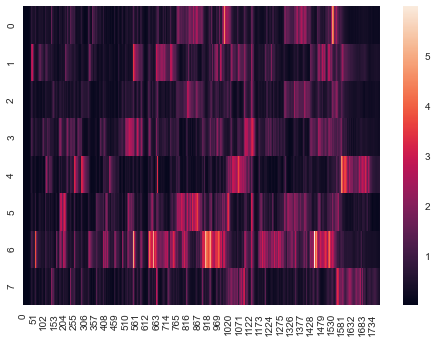

In [40]:
import torchvision.transforms as T
from scipy.interpolate import NearestNDInterpolator
from mustovi_utils import get_spec_norm
import librosa
# create zoom, rotate, shift effects
effects = ["zoom", "rotate", "shiftX", "shiftY", "shear"]
harm_effect_dict = {"rotate": 0.0}
perc_effect_dict = {"zoom": -0.5}
cqt_effect_dict = [{"zoom": 1.0}, 
                   {"rotate": 1.0},
                   {"shiftX": 1.0}, 
                   {"shiftY": 1.0},
                   {"shiftY": -1.0},
                   {"shiftX": -1.0},
                   {"rotate": -1.0},
                   {"zoom": -1.0},
                  ]
# divide song in percussion and harm (might divide in pitches later)
song_harm, song_perc = librosa.effects.hpss(song)
spec_norm_harm = get_spec_norm(song_harm)
spec_norm_perc = get_spec_norm(song_perc)
# get cqt spec
n_chroma = len(cqt_effect_dict)
cqt_spec = librosa.feature.chroma_cqt(y=song, sr=sr,hop_length=256, 
                                      n_chroma=n_chroma, n_octaves=7, 
                                      bins_per_octave=n_chroma * 4, norm=None)
sns.heatmap(cqt_spec)
plt.show()
# take window averages to match video fps
N = averaging_window
spec_norm_harm = np.convolve(spec_norm_harm, np.ones(N) / N , mode='valid')[::N]
spec_norm_perc = np.convolve(spec_norm_perc, np.ones(N) /N, mode='valid')[::N]
cqt_spec = np.array([np.convolve(cqt_line, np.ones(N) / N, mode='valid')[::N] 
                     for cqt_line in cqt_spec])
# min-max norm
spec_norm_harm = (spec_norm_harm - spec_norm_harm.min()) / (spec_norm_harm.max() - spec_norm_harm.min())
spec_norm_perc = (spec_norm_perc - spec_norm_perc.min()) / (spec_norm_perc.max() - spec_norm_perc.min())
cqt_spec = (cqt_spec - cqt_spec.min()) / (cqt_spec.max() - cqt_spec.min())
# create effects
class Effect:
    def __init__(self, strength, zoom=0, rotate=0, 
                 shiftX=0, shiftY=0, shear=0):
        max_zoom = 0.2
        self.zoom = 1 + max_zoom * zoom * strength
        max_rotate = 10
        self.rotate = max_rotate * rotate * strength
        max_shift = 10
        self.shift_x = max_shift * shiftX * strength
        self.shift_y = max_shift * shiftY * strength
        
        self.shear = 0
        
    def __call__(self, img):
        # transform it
        transformed_img = T.functional.affine(img, 
                                          angle=self.rotate, 
                                          translate=(self.shift_x,
                                                     self.shift_y), 
                                          scale=self.zoom, 
                                          shear=self.shear,
                                          fill=0,
                                          interpolation=torchvision.transforms.InterpolationMode.BILINEAR
                                         )
        # fill in zeros with nearest neighbor
        data = transformed_img.numpy()
        mask = np.where(~(data == 0))
        interp = NearestNDInterpolator(np.transpose(mask), data[mask])
        image_result = interp(*np.indices(data.shape))
        return torch.from_numpy(image_result)
        

def merge_dicts(effect_dict, effect_strength_dict, amplitude):
    for key in effect_strength_dict:
        content = effect_strength_dict[key] * amplitude
        if key in effect_dict:
            effect_dict[key] += content
        else:
            effect_dict[key] = content


effects_list = []
for i in range(len(spec_norm_harm)):
    harm = spec_norm_harm[i]
    perc = spec_norm_perc[i]
    cqt = cqt_spec[:, i]
    
    effect_dict = {}
    merge_dicts(effect_dict, harm_effect_dict, harm)
    merge_dicts(effect_dict, perc_effect_dict, perc)
    for cqt_effect, cqt_amplitude in zip(cqt_effect_dict, cqt):
        merge_dicts(effect_dict, cqt_effect, cqt_amplitude)
    
    effect = Effect(total_effect_strength, **effect_dict)
    effects_list.append([effect])

In [41]:
torch.cuda.empty_cache()
gc.collect()

7041

  0%|          | 0/443 [00:00<?, ?it/s]

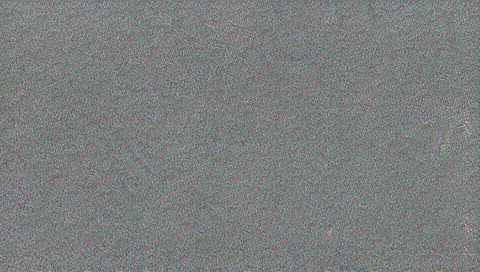

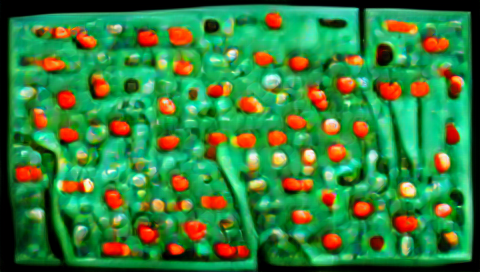

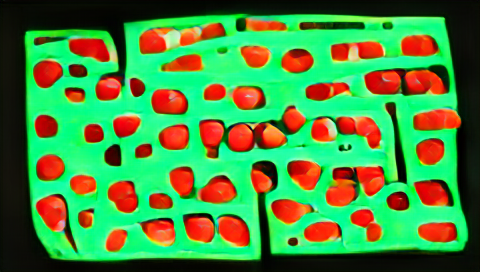

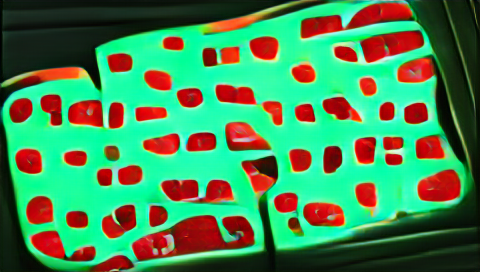

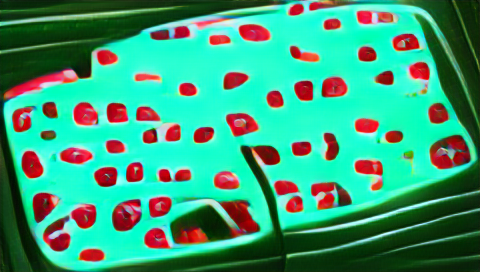

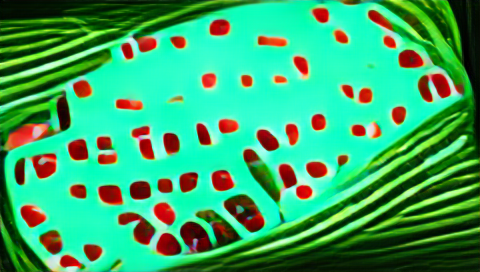

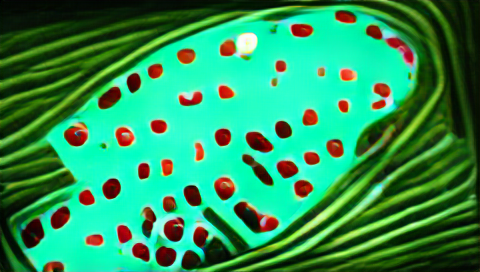

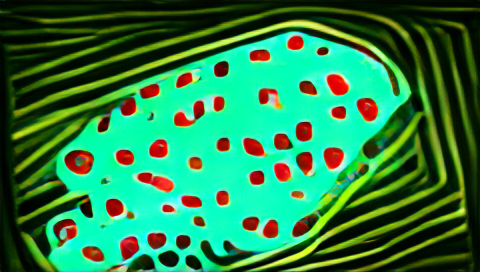

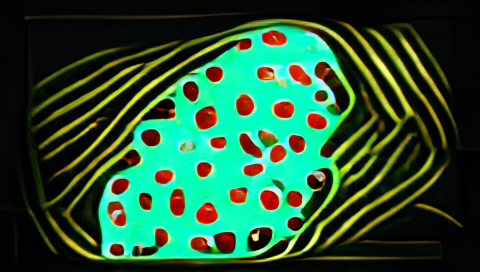

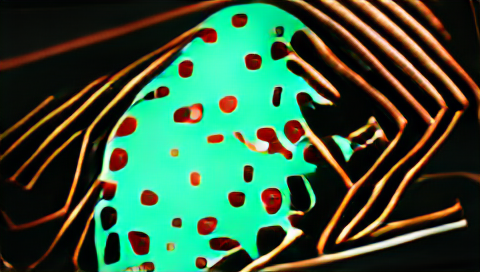

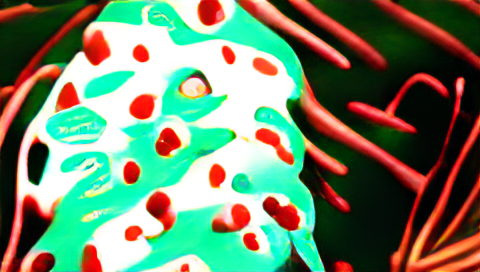

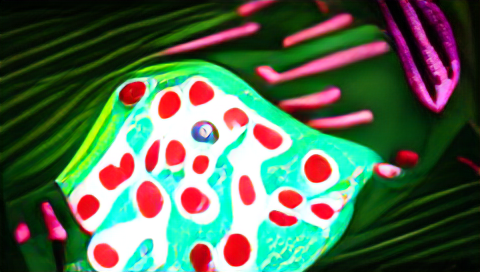

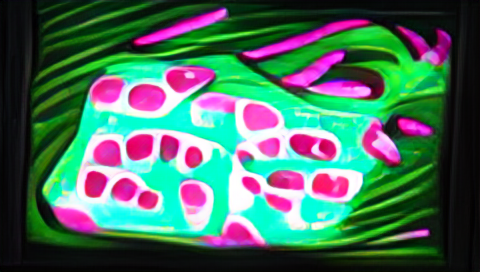

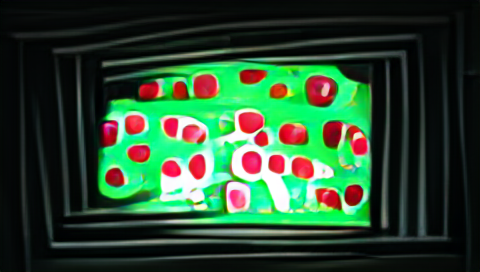

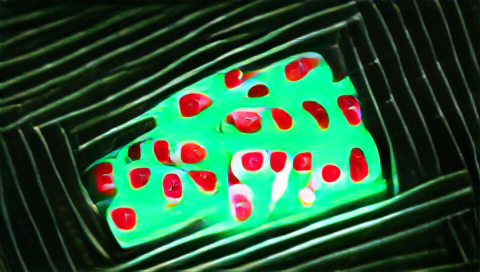

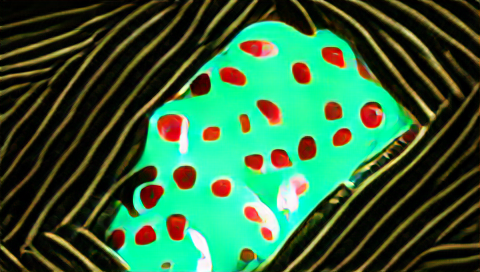

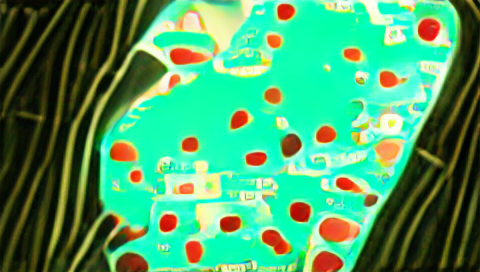

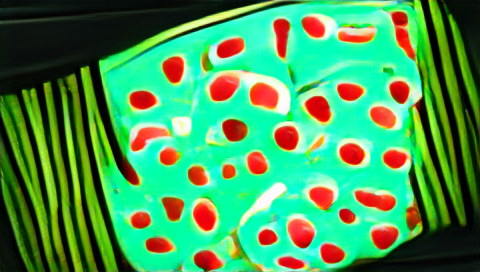

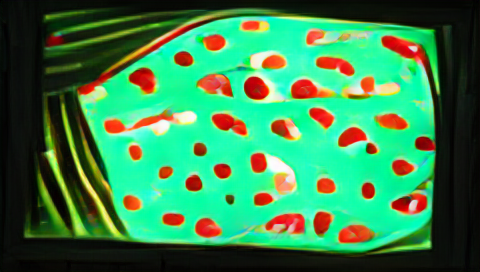

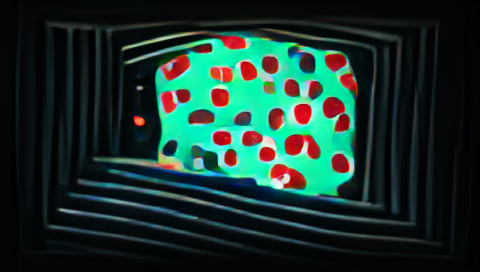

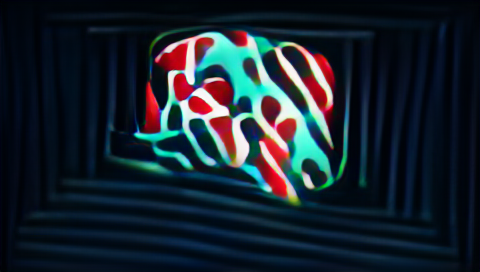

In [42]:
from tqdm.auto import tqdm
import torchvision
import tensorflow as tf
from IPython.display import display, clear_output


to_pil = torchvision.transforms.ToPILImage()


def sequential_gen(ema_encodings, effects_list):
    if len(ema_encodings) > len(effects_list):
        ema_encodings = ema_encodings[:-1]
    assert len(ema_encodings) == len(effects_list), f"{len(ema_encodings)}, {len(effects_list)}"


    img_latents = []
    img = None
    imagine.to("cuda")
    imagine.reset()
    transformed_img = None

    pbar = tqdm(list(range(len(ema_encodings))))
    for i in pbar:
        clip_encoding, effects = ema_encodings[i], effects_list[i]
        # apply effects
        if img is not None:
            transformed_img = img.float()
            for effect in effects:
                transformed_img = effect(transformed_img)
            transformed_img = transformed_img.cuda()
            latent, _, [_, _, indices] = imagine.model.model.model.encode(transformed_img.to(imagine.device).mul(2).sub(1))
            imagine.set_latent(latent)
        # set target encoding in CLIP
        clip_encoding = [part.to(imagine.device) for part in clip_encoding]
        imagine.set_clip_encoding(encoding=clip_encoding)
        # optimize for some steps
        for _ in range(sub_steps):
            img, loss = imagine.train_step(0, 0, lpips_img=transformed_img)
        img = img.detach().cpu()
        # get latent of img
        latent = imagine.model.model.get_latent().detach().cpu()
        img_latents.append(latent)
        # save final img
        if i % (len(ema_encodings) // 20) == 0:
            pil_img = to_pil(img.squeeze())

            display(pil_img)
            #clear_output(wait = True)
    return img_latents


def unflatten_encodings(encodings, enc_idcs):
    return [unflatten_encoding(enc, enc_idcs) for enc in encodings]


def unflatten_encoding(encoding, enc_idcs):
    return [encoding[idcs[0]:idcs[1]] for idcs in enc_idcs]


def get_gpt_stories_and_weights(cluster_gpt_stories, n_start_prompts, dist_to_centers, gpt_story_top_k, idx, t=50):
    if cluster_gpt_stories is not None:
        story_idx = max(idx - n_start_prompts, 0)
        dists = dist_to_centers[story_idx]
        dists = 1 - (dists / dists.max())
        dists = torch.nn.functional.softmax(dists * t, dim=-1)
        top_k = dists.topk(k=gpt_story_top_k, largest=True)
        #story_weights = (1 - (top_k.values / dist_to_centers[story_idx].max())) ** 10
        story_weights = top_k.values
        top_idcs = top_k.indices
        gpt_stories = [cluster_gpt_stories[i] for i in top_idcs]
    else:
        gpt_stories = [""]
        story_weights = [1]
    return gpt_stories, story_weights


def parallel_gen(clip_prompts):
    sub_steps = 100
    
    all_encodings = []
    for i, prompt in enumerate(clip_prompts):
        gpt_stories, story_weights = get_gpt_stories_and_weights(used_gpt_stories, n_start_prompts, 
                                                                 dist_to_centers, gpt_story_top_k, i)
        story_prompt = gpt_stories[0]
        encoding = encode(story_prompt)
        all_encodings.append(encoding)
        
    latent_dict = dict()
    
    enc_lens = [len(enc) for enc in all_encodings[0]]
    enc_idcs = []
    last_idx = 0
    for l in enc_lens:
        enc_idcs.append((last_idx, last_idx + l))
        last_idx += l
    print(enc_lens)
    print(enc_idcs)
    print(torch.cat(all_encodings[0]).shape)
    flat_targets = [torch.cat(enc).float() for enc in all_encodings]
    
    unique_targets = torch.unique(torch.stack(flat_targets), dim=0)
    print("Num unique_targets: ", len(unique_targets))
    assert len(unique_targets) < 100
    
    
    target_dict = dict()
    img_latents = []
    for i, prompt in enumerate(tqdm(clip_prompts)):
        gpt_stories, story_weights = get_gpt_stories_and_weights(used_gpt_stories, n_start_prompts, 
                                                                 dist_to_centers, gpt_story_top_k, i, t=100)
        story_prompt = gpt_stories[0]
        for story_prompt in gpt_stories:
            if story_prompt in target_dict:
                latent = target_dict[story_prompt]
            else:
                print(story_prompt)
                encoding = encode(story_prompt)
    
        #for target in flat_targets:
         #   if target in latent_dict:
         #       latent = latent_dict[target]
         #   else:
                imagine.reset()
                #unflattend_target = unflatten_encoding(target.half(), enc_idcs)
                imagine.set_clip_encoding(encoding=encoding)
                for _ in range(sub_steps):
                    img, loss = imagine.train_step(0, 0)
                latent = imagine.model.model.get_latent().detach().cpu()
                target_dict[story_prompt] = latent
                pil_img = to_pil(img.squeeze())
                display(pil_img)
        
        #if i % 10 == 0:
        #    print(story_weights)
        story_encodings = [target_dict[story_prompt] for story_prompt in gpt_stories]
        clip_encoding = torch.sum(torch.stack([enc * weight for enc, weight in zip(story_encodings, story_weights)]), dim=0) / sum(story_weights)
        img_latents.append(clip_encoding.clone())
    
    return img_latents

img_latents = sequential_gen(ema_encodings, effects_list)
#img_latents = parallel_gen(clip_prompts)

In [43]:
# take ema of encodings to smoothen
ema_latents = []
ema = img_latents[0]
for latent in img_latents:
    ema = ema_val_latent * ema.to("cpu") + (1 - ema_val) * latent.to("cpu")
    ema_latents.append(ema)

In [44]:
# interpolate between latents to increase fps and make video smoother
from mustovi_utils import slerp

goal_frame_count = boost_fps * len(song) / 16000
current_frame_count = len(ema_latents)
frames_to_add = np.ceil(goal_frame_count / current_frame_count)
if frames_to_add > 1:
    video_latents = []
    for i, latent in enumerate(ema_latents):
        if i + 1 == len(ema_latents):
            break
        else:
            next_latent = ema_latents[i + 1]
        latents_to_add = [slerp(latent, next_latent, frac) 
                          for frac in np.arange(frames_to_add) / frames_to_add]
        video_latents.extend(latents_to_add)
else:
    video_latents = ema_latents
len(video_latents)

1768

In [45]:
import torch
#torch.save(video_latents, "video_latents.pt")
#video_latents = torch.load("video_latents.pt")

In [55]:
import os
import shutil

from PIL import Image
import soundfile
import moviepy.editor as mpy
from datetime import datetime


def load_img_paths(root):
    paths = [os.path.join(root, f) for f in os.listdir(root)
        if f.endswith(".png") or f.endswith(".jpg")]
    paths = sorted(paths, key= lambda x: int(x.split("/")[-1].split("_")[0].split(".")[0]))
    return paths


def create_video(imgs, song, vid_name, sr, old_sr):
    # sr is the sample rate used to create the number of images, old_sr is the one actually used by the original song
    os.makedirs("video_gens", exist_ok=True)
    video_path = f"video_gens/{vid_name}"
    
    if isinstance(imgs, list):
        img_len = len(imgs)
    else:
        img_len = len([img for img in os.listdir(imgs) 
                       if img.endswith(".jpg") or img.endswith(".png")])
    vid_fps = len(imgs) * old_sr / len(song)

    # Write temporary audio file
    soundfile.write('tmp.wav', raw_song, old_sr)

    # Generate final video
    audio = mpy.AudioFileClip('tmp.wav', fps=old_sr)
    video = mpy.ImageSequenceClip(imgs, fps=vid_fps)
    video = video.set_audio(audio)
    video.write_videofile(video_path, audio_codec='aac', fps=vid_fps)

    # Delete temporary audio file
    os.remove('tmp.wav')

In [47]:
gc.collect()
torch.cuda.empty_cache()

In [48]:
# create latents and save to disk:
import torchvision
from tqdm.auto import tqdm
import numpy as np
import shutil

to_pil = torchvision.transforms.ToPILImage()
extension = ".jpg"
tmp_folder = "tmp/vid_imgs" 
if os.path.exists(tmp_folder):
    shutil.rmtree(tmp_folder)
os.makedirs(tmp_folder, exist_ok=True)

gen_model = imagine.model.model
imagine = imagine.cpu()
gen_model = gen_model.to("cuda")
torch.cuda.empty_cache()
gc.collect()
    
for i, latent in enumerate(tqdm(video_latents)):
    imagine.set_latent(latent)
    img = gen_model().to("cpu")
    pil_img = to_pil(img.squeeze())
    pil_img.save(os.path.join(tmp_folder, f"{i}{extension}"), subsampling=0, quality=95)

  0%|          | 0/1768 [00:00<?, ?it/s]

In [56]:
date_time = datetime.now().strftime("%m_%d_%H:%M")  #("%m/%d/%Y, %H:%M:%S")

video_name = f"{song_name.split('/')[-1].split('.')[0]}_{prompt_mode}_ema{ema_val}_steps{sub_steps}"
video_name += "_"+ gpt_theme.replace(" ", "_") if create_gpt_artstyle else ""
video_name += f"_{args['model_type']}_{date_time}.mp4"

paths = load_img_paths("tmp/vid_imgs")
create_video(paths, raw_song, video_name, sr, old_sr)

Moviepy - Building video video_gens/Blumen_top_k_ema0.2_steps1_A_beautifully_painted_composition._vqgan_11_25_19:49.mp4.
MoviePy - Writing audio in Blumen_top_k_ema0.2_steps1_A_beautifully_painted_composition._vqgan_11_25_19:49TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video video_gens/Blumen_top_k_ema0.2_steps1_A_beautifully_painted_composition._vqgan_11_25_19:49.mp4



Moviepy - Done !
Moviepy - video ready video_gens/Blumen_top_k_ema0.2_steps1_A_beautifully_painted_composition._vqgan_11_25_19:49.mp4


In [50]:
# Clone Real-ESRGAN and enter the Real-ESRGAN
if not os.path.exists("Real-ESRGAN"):
    !git clone https://github.com/xinntao/Real-ESRGAN.git
    %cd Real-ESRGAN
    # Set up the environment
    !$PYTHONPATH -m pip install basicsr facexlib gfpgan
    !$PYTHONPATH -m pip install -r requirements.txt
    !$PYTHONPATH setup.py develop
    # Download the pre-trained model
    !wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models
    !wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth -P experiments/pretrained_models
    %cd ..

In [51]:
imagine = imagine.cpu()
torch.cuda.empty_cache()
gc.collect()

21

In [52]:
import sys
sys.path.append("Real-ESRGAN")
from realesrgan import RealESRGANer
from basicsr.archs.rrdbnet_arch import RRDBNet
from PIL import Image
from tqdm import tqdm
import torch
import numpy as np

import matplotlib.pyplot as plt

@torch.inference_mode()
def upscale_imgs(imgs, out_folder=None, scale=4, tile=0):
    
    model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, 
                    num_block=23, num_grow_ch=32, scale=scale)
    upsampler = RealESRGANer(
        scale=scale,
        model_path="Real-ESRGAN/experiments/pretrained_models/RealESRGAN_x4plus.pth",
        model=model,
        tile=tile,
        tile_pad=10,
        pre_pad=0,
        half=1)
    
    outs = []
    for i, img in enumerate(tqdm(imgs)):
        if isinstance(img, str):
            img = np.array(Image.open(img))[:,:,::-1]
        
        output, _ = upsampler.enhance(img, outscale=scale)
        pil_img = Image.fromarray(output[:,:,::-1])
        
        if out_folder:
            pil_img.save(os.path.join(out_folder, f"{i}.jpg"), subsample=0, quality=95)
        else:
            outs.append(pil_img)
    return outs


import torchvision

to_tensor = torchvision.transforms.ToTensor()

@torch.inference_mode()
def upscale_imgs_custom(imgs, out_folder=None, scale=4, tile=0):
    model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, 
                    num_block=23, num_grow_ch=32, scale=scale)
    loadnet = torch.load("Real-ESRGAN/experiments/pretrained_models/RealESRGAN_x4plus.pth")
    if 'params_ema' in loadnet:
        keyname = 'params_ema'
    else:
        keyname = 'params'
    model.load_state_dict(loadnet[keyname], strict=True)
    model.eval().cuda().half()

    outs = []
    for i, img in enumerate(tqdm(imgs)):
        if isinstance(img, str):
            #img = torch.from_numpy(np.ascontiguousarray(Image.open(img))[:,:,::-1].copy()).unsqueeze(0)
            img = torch.from_numpy(np.transpose(np.array(Image.open(img))[:,:,::-1].copy(), (2, 0, 1))).float().unsqueeze(0).to("cuda")
        
        output = model(img.half()).cpu().squeeze().permute(1, 2, 0).numpy()
        #output, _ = upsampler.enhance(img, outscale=scale)
        output = (output * 255.0).round().astype(np.uint8)
        pil_img = Image.fromarray(output[:,:,::-1])
        
        if out_folder:
            pil_img.save(os.path.join(out_folder, f"{i}.jpg"), subsample=0, quality=95)
        else:
            outs.append(pil_img)
    return outs

In [53]:
import imageio

def load_images_from_mp4(path):
    vid = imageio.get_reader(path,  'ffmpeg')
    imgs = [np.array(image) for image in vid.iter_data()]
    return imgs

In [54]:
import os
import shutil

upscale = True

if upscale:
    input_folder = "tmp/vid_imgs"
    output_folder = "tmp/upscaled_vid_imgs"
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    os.makedirs(output_folder, exist_ok=True)
    
    print("Upscaling...")
    
    #video_path = "video_gens/any_colour_you_like_pink_floyd_hd_studio_quality_7032261705832661515_top_k_ema0.2_steps100Weird_and_beautiful._vqgan_11_20_14:02.mp4"
    #video_name = video_path.split("/")[0]
    #input_paths = load_images_from_mp4(video_name)
    
    input_paths = load_img_paths(input_folder)
    upscale_imgs(input_paths, out_folder=output_folder, scale=4)
    #!CUDA_VISIBLE_DEVICES=0 python Real-ESRGAN/inference_realesrgan.py --model_path Real-ESRGAN/experiments/pretrained_models/RealESRGAN_x4plus.pth --input $input_folder --output $output_folder  --netscale 4 --outscale 4 --half --face_enhance > /dev/null
    print("Done!")
    # edit name
    upscaled_video_name = video_name.split("/")
    upscaled_video_name[-1] = "HD_" + upscaled_video_name[-1]
    upscaled_video_name = "/".join(upscaled_video_name)
    # create video
    paths = load_img_paths(output_folder)
    create_video(paths, raw_song, upscaled_video_name, sr, old_sr)

Upscaling...
Done!


IndexError: list index out of range

In [ ]:
if twice_upscale:
    torch.cuda.empty_cache()
    gc.collect()
    
    input_folder = "tmp/upscaled_vid_imgs"
    output_folder = "tmp/twice_upscaled_vid_imgs"
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)    
    print("Upscaling...")
    input_paths = load_img_paths(input_folder)
    upscale_imgs(input_paths, out_folder=output_folder, scale=4)
    #!CUDA_VISIBLE_DEVICES=0 python Real-ESRGAN/inference_realesrgan.py --model_path Real-ESRGAN/experiments/pretrained_models/RealESRGAN_x2plus.pth --input  $input_folder --output $output_folder  --netscale 2 --outscale 2 --half --face_enhance > /dev/null
    print("Done!")
    # edit name
    twice_upscaled_video_name = upscaled_video_name.split("/")
    twice_upscaled_video_name[-1] = "Full" + twice_upscaled_video_name[-1]
    twice_upscaled_video_name = "/".join(twice_upscaled_video_name)
    # create video
    paths = load_img_paths(output_folder)
    create_video(paths, raw_song, twice_upscaled_video_name, old_sr)